Coding Exercise for Associate AI and Data Science Full Stack Engineer

In [538]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn import preprocessing
from scipy.stats import pearsonr



#data = data.dropna()
#print(len(data))

In [539]:
def fill_nan_one_hot(dataset, feature_cols, one_hot_cols, method='mean'):
    """
    Fills NaN values in the specified feature columns with the mean of the corresponding one-hot-encoded category.

    Parameters:
        - dataset: A Pandas DataFrame containing the data.
        - feature_cols: A list of column names (features) to fill NaN values for.
        - one_hot_cols: A list of one-hot-encoded column names defining the categories.
        - method: A string specifying the method to use for filling NaN values. Options are "mean" or "median". Default is "mean".

    Returns:
        - A Pandas DataFrame with NaN values in `feature_cols` filled based on the one-hot-encoded means.
    """
    # Input validation
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("The dataset must be a Pandas DataFrame.")
    if not all(col in dataset.columns for col in feature_cols):
        raise ValueError("Some feature columns are not present in the dataset.")
    if not all(col in dataset.columns for col in one_hot_cols):
        raise ValueError("Some one-hot columns are not present in the dataset.")
    if method not in ["mean", "median"]:
        raise ValueError("Method must be either 'mean' or 'median'.")
    
    dataset = dataset.copy()

    for feature in feature_cols:
        for one_hot_col in one_hot_cols:
            mask = dataset[one_hot_col] == 1

           # Calculate the mean or median of the feature column for this category
            if method == "mean":
                one_hot_value = dataset.loc[mask, feature].mean()
            elif method == "median":
                one_hot_value = dataset.loc[mask, feature].median()


            # Fill NaN values in the feature column for this category
            dataset.loc[mask & dataset[feature].isna(), feature] = one_hot_value

    return dataset

In [540]:
def one_hot_encoding(dataset, one_hot_col):
    """
    Performs one-hot encoding on a specified column in the dataset.

    Parameters:
        - dataset: A Pandas DataFrame containing the data.
        - one_hot_col: The name of the column to be one-hot encoded.

    Returns:
        - A new Pandas DataFrame with the one-hot-encoded columns added and the original column dropped.
    """
    # Ensure valid input
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("dataset must be a Pandas DataFrame.")
    if one_hot_col not in dataset.columns:
        raise ValueError(f"Column '{one_hot_col}' is not present in the dataset.")
    
    # Perform one-hot encoding
    one_hot_encoded = pd.get_dummies(dataset[one_hot_col])
    
    # Concatenate the one-hot-encoded columns to the dataset
    dataset_encoded = pd.concat([dataset, one_hot_encoded], axis=1)
    
    # Drop the original column
    dataset_encoded = dataset_encoded.drop(one_hot_col, axis=1)
    
    return dataset_encoded


In [541]:
# Import and view data
data = pd.read_csv(r'housing.csv')
#print(data.describe())

# perform one-hot encoding
encoded_data = one_hot_encoding(data, 'ocean_proximity')

#print(encoded_data.info())
#fillna_encoded_data = fill_nan_one_hot(encoded_data, encoded_data[encoded_data.columns[:9]], encoded_data[encoded_data.columns[9:14]], method='mean')
fillna_encoded_data = encoded_data.dropna()
#print(abs((encoded_data.mean()-fillna_encoded_data.mean())/encoded_data.mean())*100) # dropna: less than 0.04% change in all features | mean:0.002% change in the mean of total_bedrooms
#print(abs((encoded_data.median()-fillna_encoded_data.median())/encoded_data.median())*100) # dropna: less than 0.05% change in all features | mean:0.689% change in the median of total_bedrooms
encoded_data = fillna_encoded_data
#print(abs((encoded_data.mean()-encoded_data.median())/encoded_data.mean())*100)
#print(encoded_data.describe())


In [542]:
def plot_geospatial_data(dataset, geo_cols, feature_cols, one_hot_cols, one_hot_title, tot_rows, tot_cols, figsize, output_file="geospacial_data.png"):
    """
    Plots geospatial data distributions and category-specific scatter plots.

    Parameters:
        - encoded_data: Pandas DataFrame containing the data to be plotted.
        - feature_cols: List of feature column names to be visualized in individual scatter plots (e.g., features 2 to 8).
        - one_hot_cols: List of one-hot-encoded column names (e.g., proximity labels) for the combined scatter plot.
        - one_hot_title: String that describes all the one_hot_cols.
        - tot_rows: Number of rows in the subplot grid (must be a positive integer).
        - tot_cols: Number of columns in the subplot grid (must be a positive integer).
        - figsize: Tuple specifying the size of the figure (width, height), both must be positive numbers.
        - output_file: Name of the file to save the generated plot. Defaults to 'geospacial_data.png'.
    """
    # Input validation
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("dataset must be a Pandas DataFrame.")
    if not isinstance(geo_cols, (list, pd.Index)) or not all(isinstance(col, str) for col in geo_cols):
        raise TypeError("geo_cols must be a list of column names (strings) or Pandas Index.")
    if not isinstance(feature_cols, (list, pd.Index)) or not all(isinstance(col, str) for col in feature_cols):
        raise TypeError("feature_cols must be a list of column names (strings) or Pandas Index.")
    if not isinstance(one_hot_cols, (list, pd.Index)) or not all(isinstance(col, str) for col in one_hot_cols):
        raise TypeError("one_hot_cols must be a list of column names (strings).")
    if not isinstance(one_hot_title, str):
        raise TypeError("one_hot_title must be a string.")
    if not isinstance(tot_rows, int) or tot_rows <= 0:
        raise ValueError("tot_rows must be a positive integer.")
    if not isinstance(tot_cols, int) or tot_cols <= 0:
        raise ValueError("tot_cols must be a positive integer.")
    if not isinstance(figsize, tuple) or len(figsize) != 2 or not all(isinstance(val, (int, float)) and val > 0 for val in figsize):
        raise ValueError("figsize must be a tuple of two positive numbers (width, height).")
    if not isinstance(output_file, str):
        raise TypeError("output_file must be a string representing the file name.")
    
    # Check if the number of subplots is compatible with the features to be plotted
    if tot_cols*tot_rows != (len(feature_cols)+1): # +1 the categorical cols are plotted in one subplot (remember one hot encoding)
        print('WARNING: The total number of subplots is not compatible with the total number of features.')

    alpha = 0.7
    fig, axs = plt.subplots(tot_rows, tot_cols, figsize=figsize)
    row, col = 0, 0
    
    # Plot scatter plots for feature_cols
    for feature in feature_cols:
        ax = axs[row, col]
        min_f, max_f = dataset[feature].min(), dataset[feature].max()
        scatter_plot = ax.scatter(dataset[geo_cols[0]], dataset[geo_cols[1]], s=1, c=dataset[feature], cmap='jet', alpha=alpha)
        ax.set_title(feature)
        ax.axis('equal')
        
        # Add colorbar as an inset
        cbaxes = inset_axes(ax, width="3%", height="30%", loc=1)
        plt.colorbar(scatter_plot, cax=cbaxes, ticks=[min_f, (max_f - min_f) / 2, max_f], orientation='vertical', location='left'
        )
        
        # Update row and column indices
        col += 1
        if col >= tot_cols:
            row += 1
            col = 0
    
    # Plot category-based scatter plots
    ax = axs[row, col]
    for i, one_hot_col in enumerate(one_hot_cols):
        one_hot_data = dataset.where(dataset[one_hot_col] == 1).dropna()
        colormap = ['green', 'brown', 'blue', 'red', 'cyan', 'purple', 'yellow', 'orange']
        ax.scatter(one_hot_data[geo_cols[0]], one_hot_data[geo_cols[1]], s=2.5, color=colormap[i], label=one_hot_col, alpha=alpha)
    
    ax.set_title(one_hot_title)
    ax.legend()

    # Customize the figure
    for ax in fig.get_axes():
        ax.label_outer()
    fig.supxlabel(geo_cols[0], fontsize=14)
    fig.supylabel(geo_cols[1], fontsize=14)
    fig.suptitle("GEOSPACIAL DATA DISTRIBUTION\n", fontsize=16)
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()


C:\Users\mvran\AppData\Local\Temp\ipykernel_2592\3031665252.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


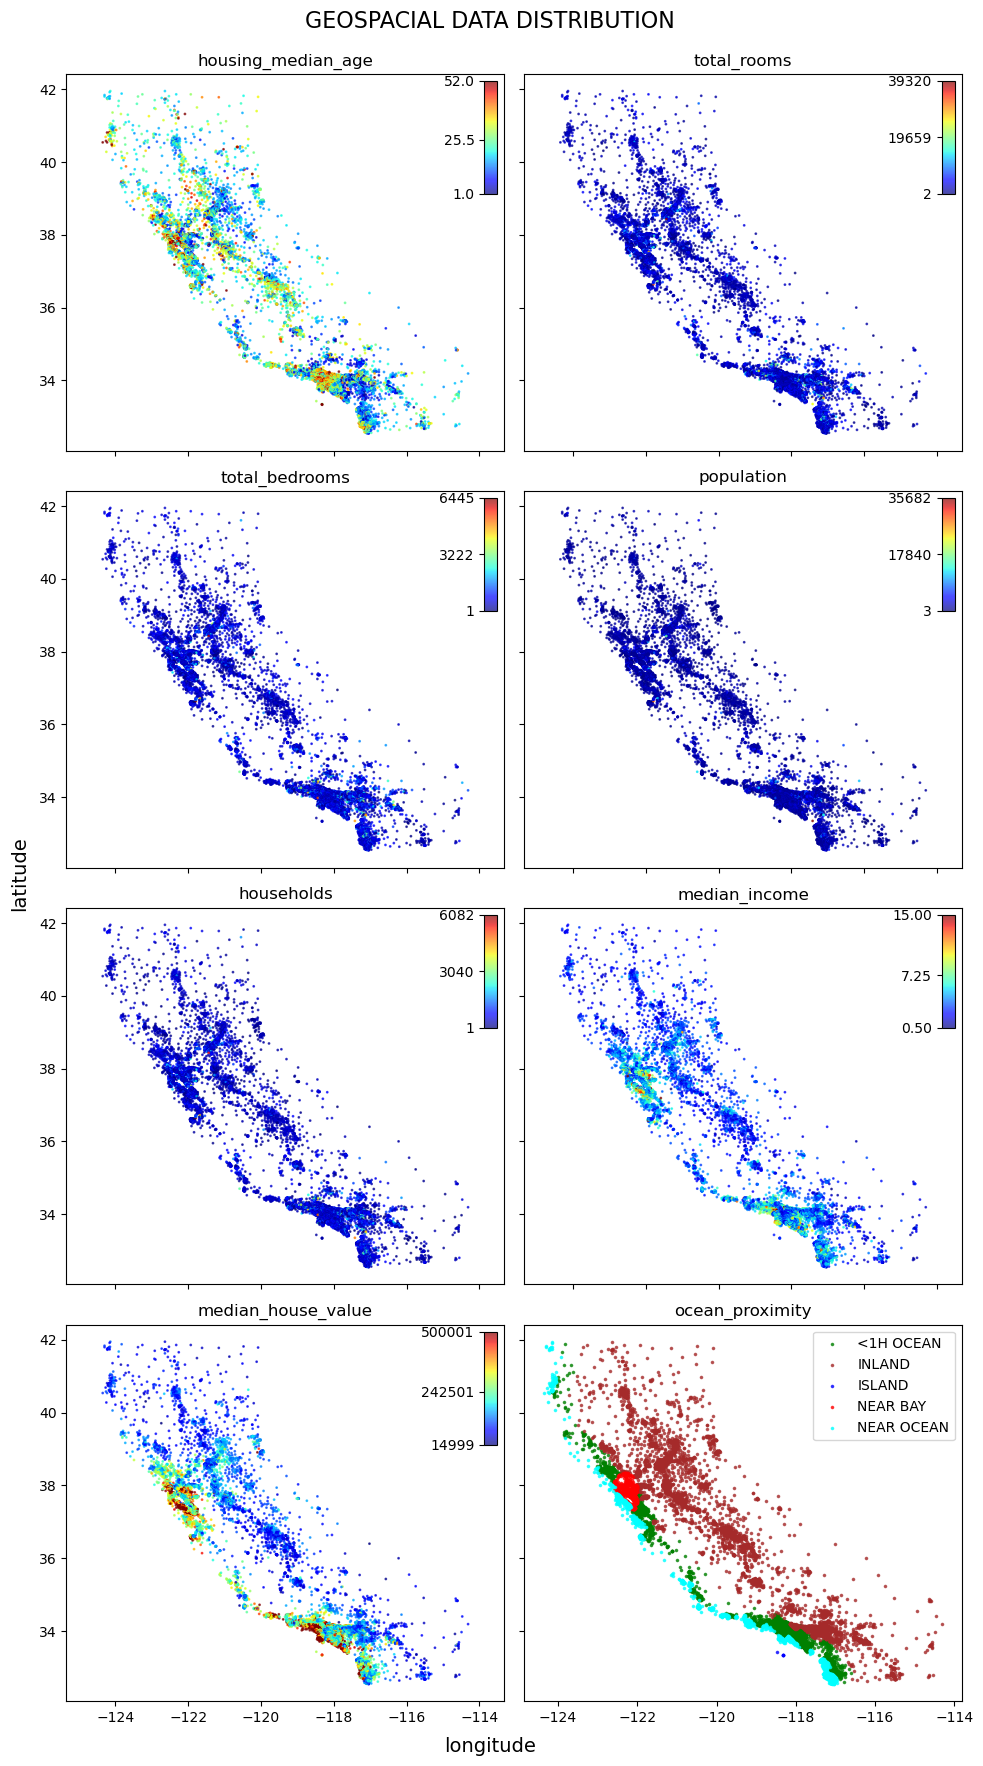

In [543]:
# Plot geospacial data distribution
plot_geospatial_data(
    dataset=encoded_data,
    geo_cols=encoded_data.columns[0:2],
    feature_cols=encoded_data.columns[2:9], 
    one_hot_cols=encoded_data.columns[9:14],
    one_hot_title='ocean_proximity', 
    tot_rows=4, 
    tot_cols=2, 
    figsize=(10, 18))

C:\Users\mvran\AppData\Local\Temp\ipykernel_2592\3031665252.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


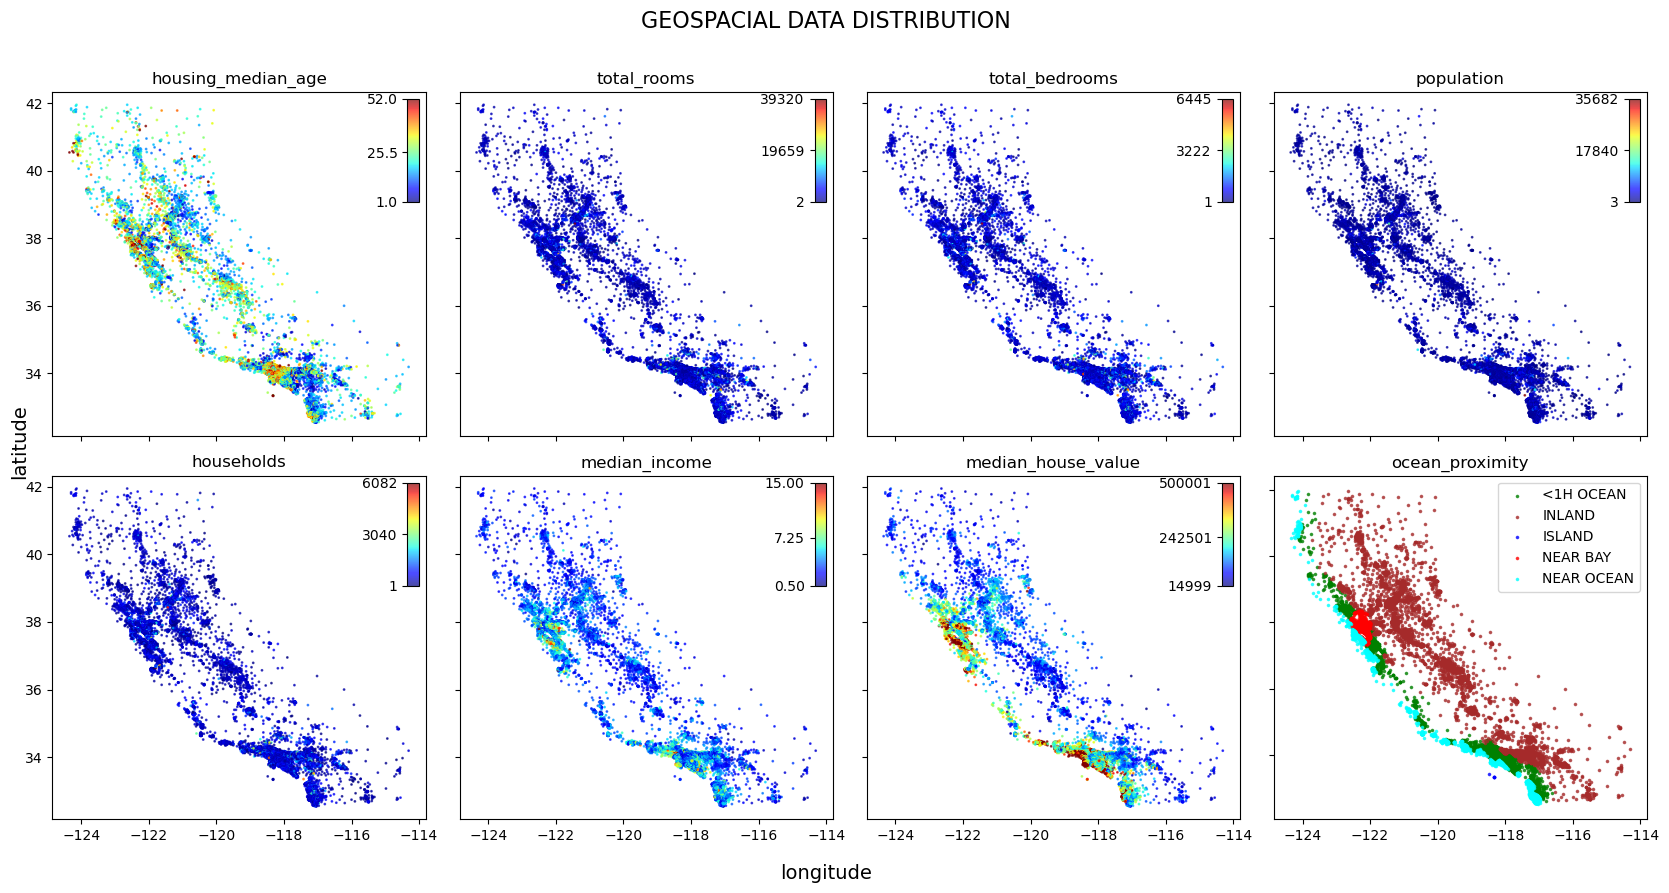

In [544]:
plot_geospatial_data(
    dataset=encoded_data,
    geo_cols=encoded_data.columns[0:2],
    feature_cols=encoded_data.columns[2:9], 
    one_hot_cols=encoded_data.columns[9:14],
    one_hot_title='ocean_proximity', 
    tot_rows=2, 
    tot_cols=4, 
    figsize=(17, 9),
    output_file="geospacial_data_h.png")

In [545]:
def custom_hist(feature, bins, ax):
    """ This function creates a customized histogram of numerical data with automatic scaling for the y-axis (linear or logarithmic) based on the range of counts in the bins.

        Parameters:
            - feature: A 1D array-like structure (e.g., numpy array, pandas Series, or list) containing numerical data to be visualized in the histogram.
            - bins: An integer specifying the number of bins for the histogram. This determines how the data is divided into intervals. Must be a positive integer.
            - ax: A Matplotlib Axes object where the histogram will be plotted. This allows for integration into larger plots or subplots. 
                
        Returns:
            * None. The function directly modifies the provided Axes object to include the histogram.
    """
        # Validate inputs
    if not isinstance(feature, (np.ndarray, list, pd.Series)):
        raise TypeError("Feature must be a 1D numpy array or list of numerical values.")
    if isinstance(bins, int) and bins <= 0:
        raise ValueError("Bins must be a positive integer.")
    if not hasattr(ax, "plot"):
        raise TypeError("Ax must be a valid matplotlib Axes object.")
    try:
        counts, bin_edges = np.histogram(feature, bins)
        c_max = max(counts)
        c_min = min(counts)
        y_scale = "linear"
        if c_max-c_min > 5000:
            y_scale = "log"
        ax.stairs(counts, bin_edges, fill = True, facecolor = 'purple')
        ax.grid(alpha=0.6, linewidth=0.2)
        ax.set_title(feature.name if hasattr(feature, 'name') else "Custom Histogram")
        ax.set_yscale(y_scale)
    except Exception as e:
        print(f"An error occurred: {e}")


In [546]:
def plot_data_distribution(dataset, feature_cols, one_hot_cols, one_hot_title, bins, tot_rows, tot_cols, figsize, output_file="data_distribution.png"):
    """
    Plots histograms for selected features and a bar chart for one-hot-encoded column frequencies.

    Parameters:
        - dataset: Pandas DataFrame containing the data to be plotted.
        - features: List of numerical feature column names to plot histograms for.
        - one_hot_cols: List of one-hot-encoded column names to plot frequency distributions for.
        - one_hot_title: String that describes the one_hot_cols.
        - bins: Number of bins for the histograms. 
        - tot_rows: Number of rows in the subplot grid. 
        - tot_cols: Number of columns in the subplot grid.
        - figsize: Tuple specifying the figure size (width, height).
        - output_file: Name of the file to save the generated plot. Default is 'data_distribution.png'.

    Returns:
        None. Displays the plots and saves the figure as a file.
    """
    # Validate inputs
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("dataset must be a Pandas DataFrame.")
    if not isinstance(feature_cols, (list, pd.Index)) or not all(isinstance(f, str) for f in feature_cols):
        raise TypeError("features must be a list of column names (strings) or Pandas Index.")
    if not isinstance(one_hot_cols, (list, pd.Index)) or not all(isinstance(c, str) for c in one_hot_cols):
        raise TypeError("one_hot_columns must be a list of column names (strings) or Pandas Index.")
    if not all(col in dataset.columns for col in feature_cols):
        raise ValueError("Some feature columns are not present in the dataset.")
    if not all(col in dataset.columns for col in one_hot_cols):
        raise ValueError("Some one-hot columns are not present in the dataset.")
    if not isinstance(one_hot_title, str):
        raise TypeError("one_hot_title must be a string.")
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError("bins must be a positive integer.")
    if not isinstance(tot_rows, int) or tot_rows <= 0:
        raise ValueError("tot_rows must be a positive integer.")
    if not isinstance(tot_cols, int) or tot_cols <= 0:
        raise ValueError("tot_cols must be a positive integer.")
    if not isinstance(figsize, tuple) or len(figsize) != 2 or not all(isinstance(val, (int, float)) and val > 0 for val in figsize):
        raise ValueError("figsize must be a tuple of two positive numbers (width, height).")
    if not isinstance(output_file, str):
        raise TypeError("output_file must be a string.")
    
    # Check if the number of subplots is compatible with the features to be plotted
    if tot_cols*tot_rows != (len(feature_cols)+1): # +1 the categorical cols are plotted in one subplot (remember one hot encoding)
        print('WARNING: The total number of subplots is not compatible with the total number of features.')

    # Prepare the plot grid
    fig, axs = plt.subplots(tot_rows, tot_cols, figsize=figsize)
    row, col = 0, 0

    # Plot histograms for numerical features
    for feature in feature_cols:
        ax = axs[row, col]
        try:
            counts, bin_edges = np.histogram(dataset[feature], bins)
            c_max = max(counts)
            c_min = min(counts)
            y_scale = 'linear'
            if c_max-c_min > 5000:
                y_scale = 'log'
            ax.stairs(counts, bin_edges, fill = True, facecolor = 'purple')
            ax.grid(alpha=0.6, linewidth=0.2)
            ax.set_title(feature)
            ax.set_yscale(y_scale)
            ax.tick_params(axis='x', labelsize=8)
        except Exception as e:
            print(f"An error occurred: {e}")
        col += 1
        if col >= tot_cols:
            row += 1
            col = 0

    # Compute and plot a combined bar chart for one-hot-encoded columns
    one_hot_counts = []
    for one_hot_col in one_hot_cols:
        one_hot_data = dataset.where(dataset[one_hot_col] == 1).dropna()
        one_hot_counts.append(len(one_hot_data))

    c_max = max(one_hot_counts)
    c_min = min(one_hot_counts)
    if c_max-c_min > 5000:
        y_scale = 'True' # log = True
    else:
        y_scale = 'False' # log = False
    ax = axs[row, col]
    ax.bar(one_hot_cols, one_hot_counts, log=y_scale, facecolor = 'purple')
    ax.set_title(one_hot_title)
    ax.tick_params(axis='x', labelsize=8)
    ax.grid(axis='y',which='both' , alpha=0.6, linewidth=0.2)

    # Add overall titles and labels
    fig.suptitle("DATA DISTRIBUTION", fontsize=16)
    fig.supylabel("counts", fontsize=14)
    fig.supxlabel("values", fontsize=14)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()


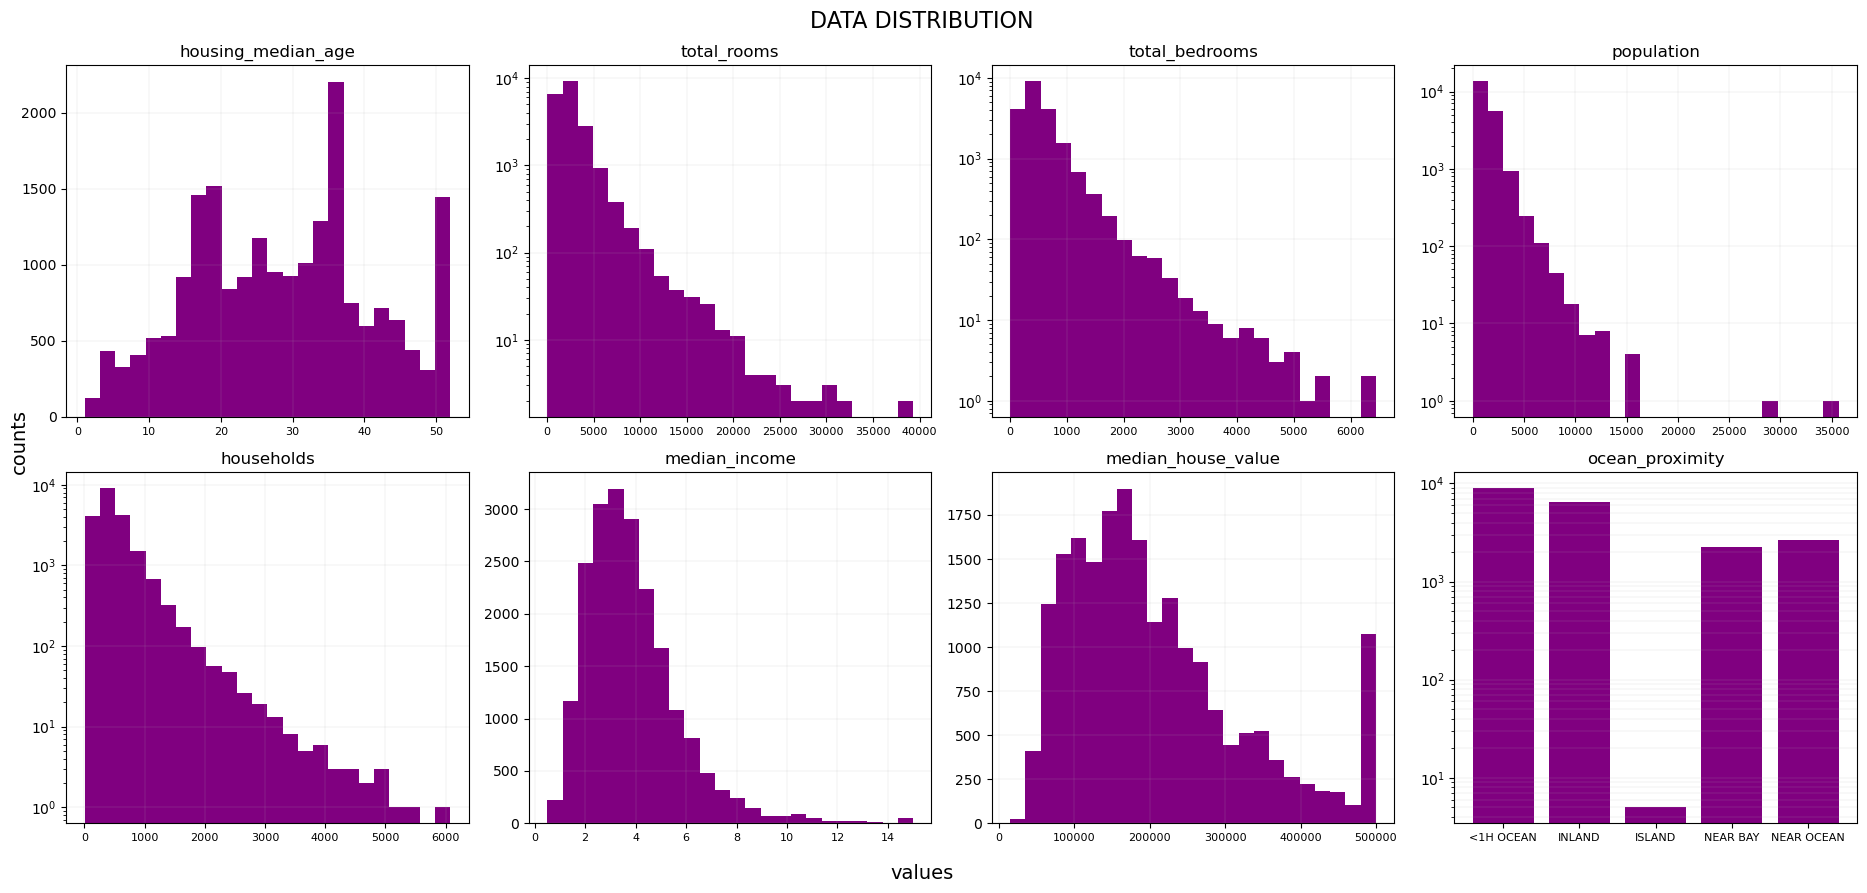

In [547]:
plot_data_distribution(
    dataset=encoded_data, 
    feature_cols=encoded_data.columns[2:9], 
    one_hot_cols=encoded_data.columns[9:14], 
    one_hot_title='ocean_proximity', 
    bins=24, 
    tot_rows=2, 
    tot_cols=4, 
    figsize=(19, 9), 
    output_file="data_distribution_h.png")

In [548]:
def scale_cols(dataset, cols_to_scale):
    """
    Scales specified columns in the dataset using MinMaxScaler and updates the dataset in place.

    Parameters:
        - dataset: A Pandas DataFrame containing the data to scale.
        - cols_to_scale: A list of column names to scale using MinMaxScaler.
    
    Returns:
        - A Pandas DataFrame with the specified columns scaled to a [0, 1] range.
    """
    # Validate inputs
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("The dataset must be a Pandas DataFrame.")
    if not all(col in dataset.columns for col in cols_to_scale):
        raise ValueError("Some features in 'features' are not present in the dataset.")

    # Create a MinMaxScaler
    scaler = preprocessing.MinMaxScaler()

    # Scale the specified columns and replace the original values
    dataset[cols_to_scale] = scaler.fit_transform(dataset[cols_to_scale])

    return dataset

In [549]:
# Feature normalization (min-max scaling)

scaled_data = scale_cols(encoded_data, encoded_data.columns[2:9])


In [550]:
def plot_one_hot_boxplot(dataset, feature_cols, one_hot_cols, one_hot_title, tot_rows, tot_cols, figsize, output_file="box_plot.png"):
    """
    Plots histograms for selected features and a bar chart for one-hot-encoded column frequencies.

    Parameters:
        - dataset: Pandas DataFrame containing the data to be plotted. For better visualization the values should be normalized.
        - features: List of numerical feature column names to plot histograms for.
        - one_hot_cols: List of one-hot-encoded column names to plot frequency distributions for.
        - one_hot_title: String that describes the one_hot_cols.
        - tot_rows: Number of rows in the subplot grid. 
        - tot_cols: Number of columns in the subplot grid.
        - figsize: Tuple specifying the figure size (width, height).
        - output_file: Name of the file to save the generated plot. Default is 'data_distribution.png'.

    Returns:
        None. Displays the plots and saves the figure as a file.
    """
    # Validate inputs
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("dataset must be a Pandas DataFrame.")
    if not isinstance(feature_cols, (list, pd.Index)) or not all(isinstance(f, str) for f in feature_cols):
        raise TypeError("feature_cols must be a list of column names (strings) or Pandas Index.")
    if not isinstance(one_hot_cols, (list, pd.Index)) or not all(isinstance(c, str) for c in one_hot_cols):
        raise TypeError("one_hot_cols must be a list of column names (strings)or Pandas Index.")
    if not all(col in dataset.columns for col in feature_cols):
        raise ValueError("Some feature columns are not present in the dataset.")
    if not all(col in dataset.columns for col in one_hot_cols):
        raise ValueError("Some one-hot columns are not present in the dataset.")
    if not isinstance(one_hot_title, str):
        raise TypeError("one_hot_title must be a string.")
    if not isinstance(tot_rows, int) or tot_rows <= 0:
        raise ValueError("tot_rows must be a positive integer.")
    if not isinstance(tot_cols, int) or tot_cols <= 0:
        raise ValueError("tot_cols must be a positive integer.")
    if not isinstance(figsize, tuple) or len(figsize) != 2 or not all(isinstance(val, (int, float)) and val > 0 for val in figsize):
        raise ValueError("figsize must be a tuple of two positive numbers (width, height).")
    if not isinstance(output_file, str):
        raise TypeError("output_file must be a string.")
    
    # Check if the number of subplots is compatible with the features to be plotted
    if tot_cols*tot_rows != (len(one_hot_cols)+1): # +1 for all one_hot_cols combined.
        print('WARNING: The total number of subplots is not compatible with the total number of features.')

    # Prepare the plot grid
    fig, axs = plt.subplots(tot_rows, tot_cols, figsize=figsize)
    row, col = 0, 0
    
    ax = axs[row,col]
    ax.boxplot(dataset[feature_cols], showmeans= True, meanline= True, flierprops= {"marker": "o", "markersize": 0.4}, labels = feature_cols)
    ax.set_title("ALL DATA")
    ax.tick_params(axis='x', labelsize=12, rotation=40)
    ax.grid(axis="y", alpha=0.6, linewidth=0.2)
    col += 1
    
    for one_hot_col in one_hot_cols:
        ax =  axs[row,col]
        one_hot_data = dataset.where(dataset[one_hot_col] == 1).dropna()
        one_hot_data = one_hot_data[feature_cols]
        ax.boxplot(one_hot_data, showmeans= True, meanline= True, flierprops= {"marker": "o", "markersize": 0.4}, labels = feature_cols)
        ax.set_title(one_hot_col)
        ax.tick_params(axis='x', labelsize=12, rotation=40)
        ax.grid(axis="y", alpha=0.6, linewidth=0.2)
        col = col + 1
        if col >= tot_cols:
            row = row + 1
            col = 0

    for ax in fig.get_axes():
        ax.label_outer()

    fig.suptitle(f"DISTRIBUTION OF NORMALIZED FEATURES BY {one_hot_title}", fontsize=16)
    fig.supylabel("normalized values\n", fontsize=14)
    fig.supxlabel("features", fontsize=14)
    plt.tight_layout()
    plt.savefig("box_plot.png")
    plt.show()

    

        

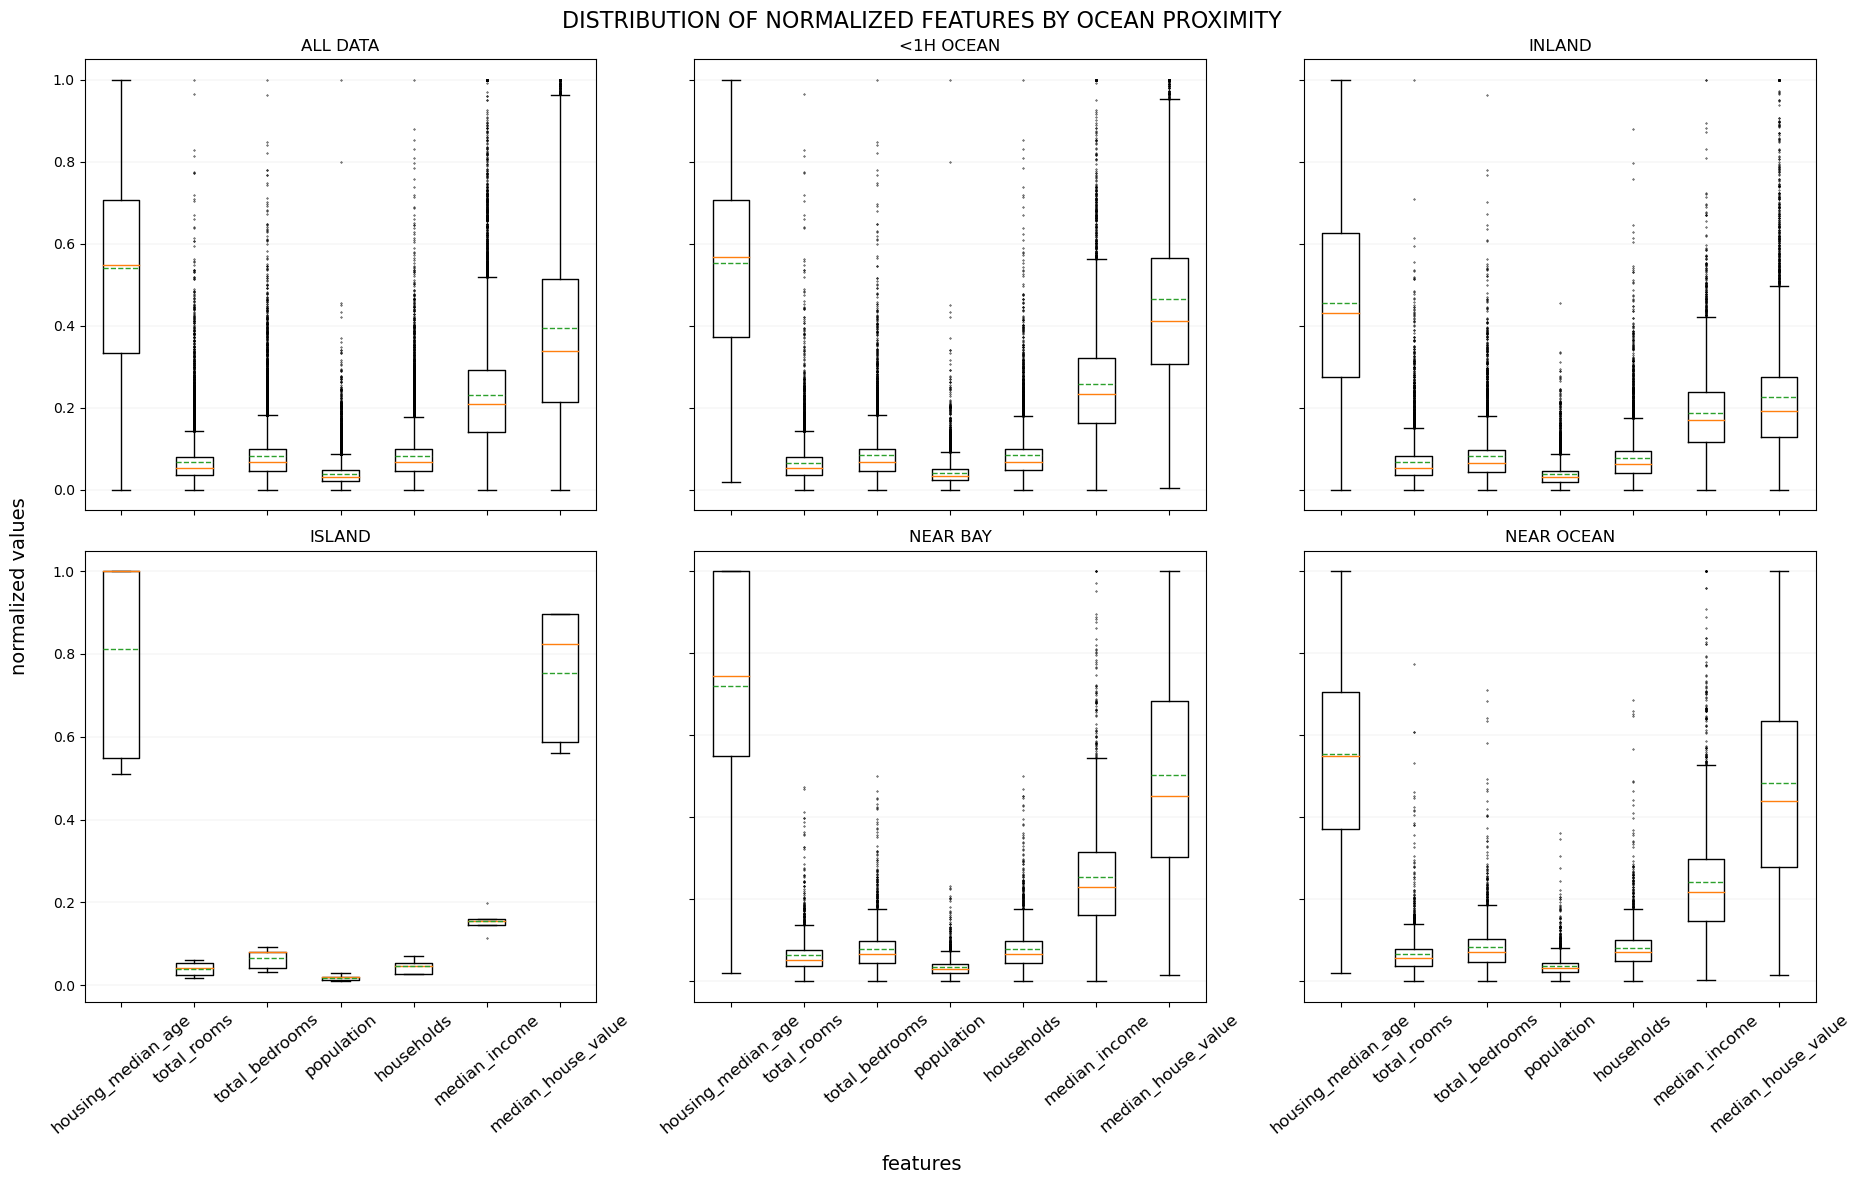

In [551]:
# Plot box plots
plot_one_hot_boxplot(
    dataset=scaled_data, 
    feature_cols=scaled_data.columns[2:9], 
    one_hot_cols=scaled_data.columns[9:14], 
    one_hot_title='OCEAN PROXIMITY', 
    tot_rows=2, 
    tot_cols=3, 
    figsize=(19,12), 
    output_file="box_plot.png")

In [552]:
print(len(scaled_data.where(scaled_data["ISLAND"]==1).dropna()))

5


In [553]:
def plot_one_hot_corr_matrix(dataset, feature_cols, one_hot_cols, one_hot_title, tot_rows, tot_cols, figsize, output_file="correlation_matrix.png"):
    """
    Plots histograms for selected features and a bar chart for one-hot-encoded column frequencies.

    Parameters:
        - dataset: Pandas DataFrame containing the data to be plotted. For better visualization the values should be normalized.
        - features: List of numerical feature column names to plot histograms for.
        - one_hot_cols: List of one-hot-encoded column names to plot frequency distributions for.
        - one_hot_title: String that describes the one_hot_cols.
        - tot_rows: Number of rows in the subplot grid. 
        - tot_cols: Number of columns in the subplot grid.
        - figsize: Tuple specifying the figure size (width, height).
        - output_file: Name of the file to save the generated plot. Default is 'data_distribution.png'.

    Returns:
        None. Displays the plots and saves the figure as a file.
    """
    # Validate inputs
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("dataset must be a Pandas DataFrame.")
    if not isinstance(feature_cols, (list, pd.Index)) or not all(isinstance(f, str) for f in feature_cols):
        raise TypeError("features must be a list of column names (strings) or Pandas Index.")
    if not isinstance(one_hot_cols, (list, pd.Index)) or not all(isinstance(c, str) for c in one_hot_cols):
        raise TypeError("one_hot_columns must be a list of column names (strings) or Pandas Index.")
    if not all(col in dataset.columns for col in feature_cols):
        raise ValueError("Some feature columns are not present in the dataset.")
    if not all(col in dataset.columns for col in one_hot_cols):
        raise ValueError("Some one-hot columns are not present in the dataset.")
    if not isinstance(one_hot_title, str):
        raise TypeError("one_hot_title must be a string.")
    if not isinstance(tot_rows, int) or tot_rows <= 0:
        raise ValueError("tot_rows must be a positive integer.")
    if not isinstance(tot_cols, int) or tot_cols <= 0:
        raise ValueError("tot_cols must be a positive integer.")
    if not isinstance(figsize, tuple) or len(figsize) != 2 or not all(isinstance(val, (int, float)) and val > 0 for val in figsize):
        raise ValueError("figsize must be a tuple of two positive numbers (width, height).")
    if not isinstance(output_file, str):
        raise TypeError("output_file must be a string.")
    
    # Check if the number of subplots is compatible with the features to be plotted
    if tot_cols*tot_rows != (len(one_hot_cols)+1): # +1 for all one_hot_cols combined.
        print('WARNING: The total number of subplots is not compatible with the total number of features.')

    # Prepare the plot grid
    fig, axs = plt.subplots(tot_rows, tot_cols, figsize=figsize)
    row, col = 0, 0
    matrix = dataset[feature_cols].corr()
    ax = axs[row,col]
    m_plot = ax.imshow(matrix, cmap='bwr', vmin=-1, vmax=1)
    plt.colorbar(m_plot, shrink = 0.8)
    ax.set_title("ALL DATA")
    ax.set_xticks(range(len(matrix)), feature_cols, rotation=45, ha='right')
    ax.set_yticks(range(len(matrix)), feature_cols)
    for i in range(len(feature_cols)):
        for j in range(len(feature_cols)):
            ax.text(i, j, round(matrix[feature_cols[i]][feature_cols[j]],2), ha="center", va="center", color='black', alpha=0.5)
    col += 1
    
    for one_hot_col in one_hot_cols:
        ax =  axs[row,col]
        one_hot_data = dataset.where(dataset[one_hot_col] == 1).dropna()
        one_hot_data = one_hot_data[feature_cols]
        matrix = one_hot_data.corr()
        m_plot = ax.imshow(matrix, cmap='bwr', vmin=-1, vmax=1)
        plt.colorbar(m_plot, shrink = 0.8)
        ax.set_title(one_hot_col)
        ax.set_xticks(range(len(matrix)), feature_cols, rotation=45, ha='right')
        ax.set_yticks(range(len(matrix)), feature_cols)
        for i in range(len(feature_cols)):
            for j in range(len(feature_cols)):
                ax.text(i, j, round(matrix[feature_cols[i]][feature_cols[j]],2), ha="center", va="center", color='black', alpha=0.5)
        col = col + 1
        if col >= tot_cols:
            row = row + 1
            col = 0

    for ax in fig.get_axes():
        ax.label_outer()

    fig.suptitle(f"CORRELATION MATRICES OF NORMALIZED FEATURES BY {one_hot_title}", fontsize=16)
    fig.supylabel("features\n", fontsize=14)
    fig.supxlabel("features", fontsize=14)
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()

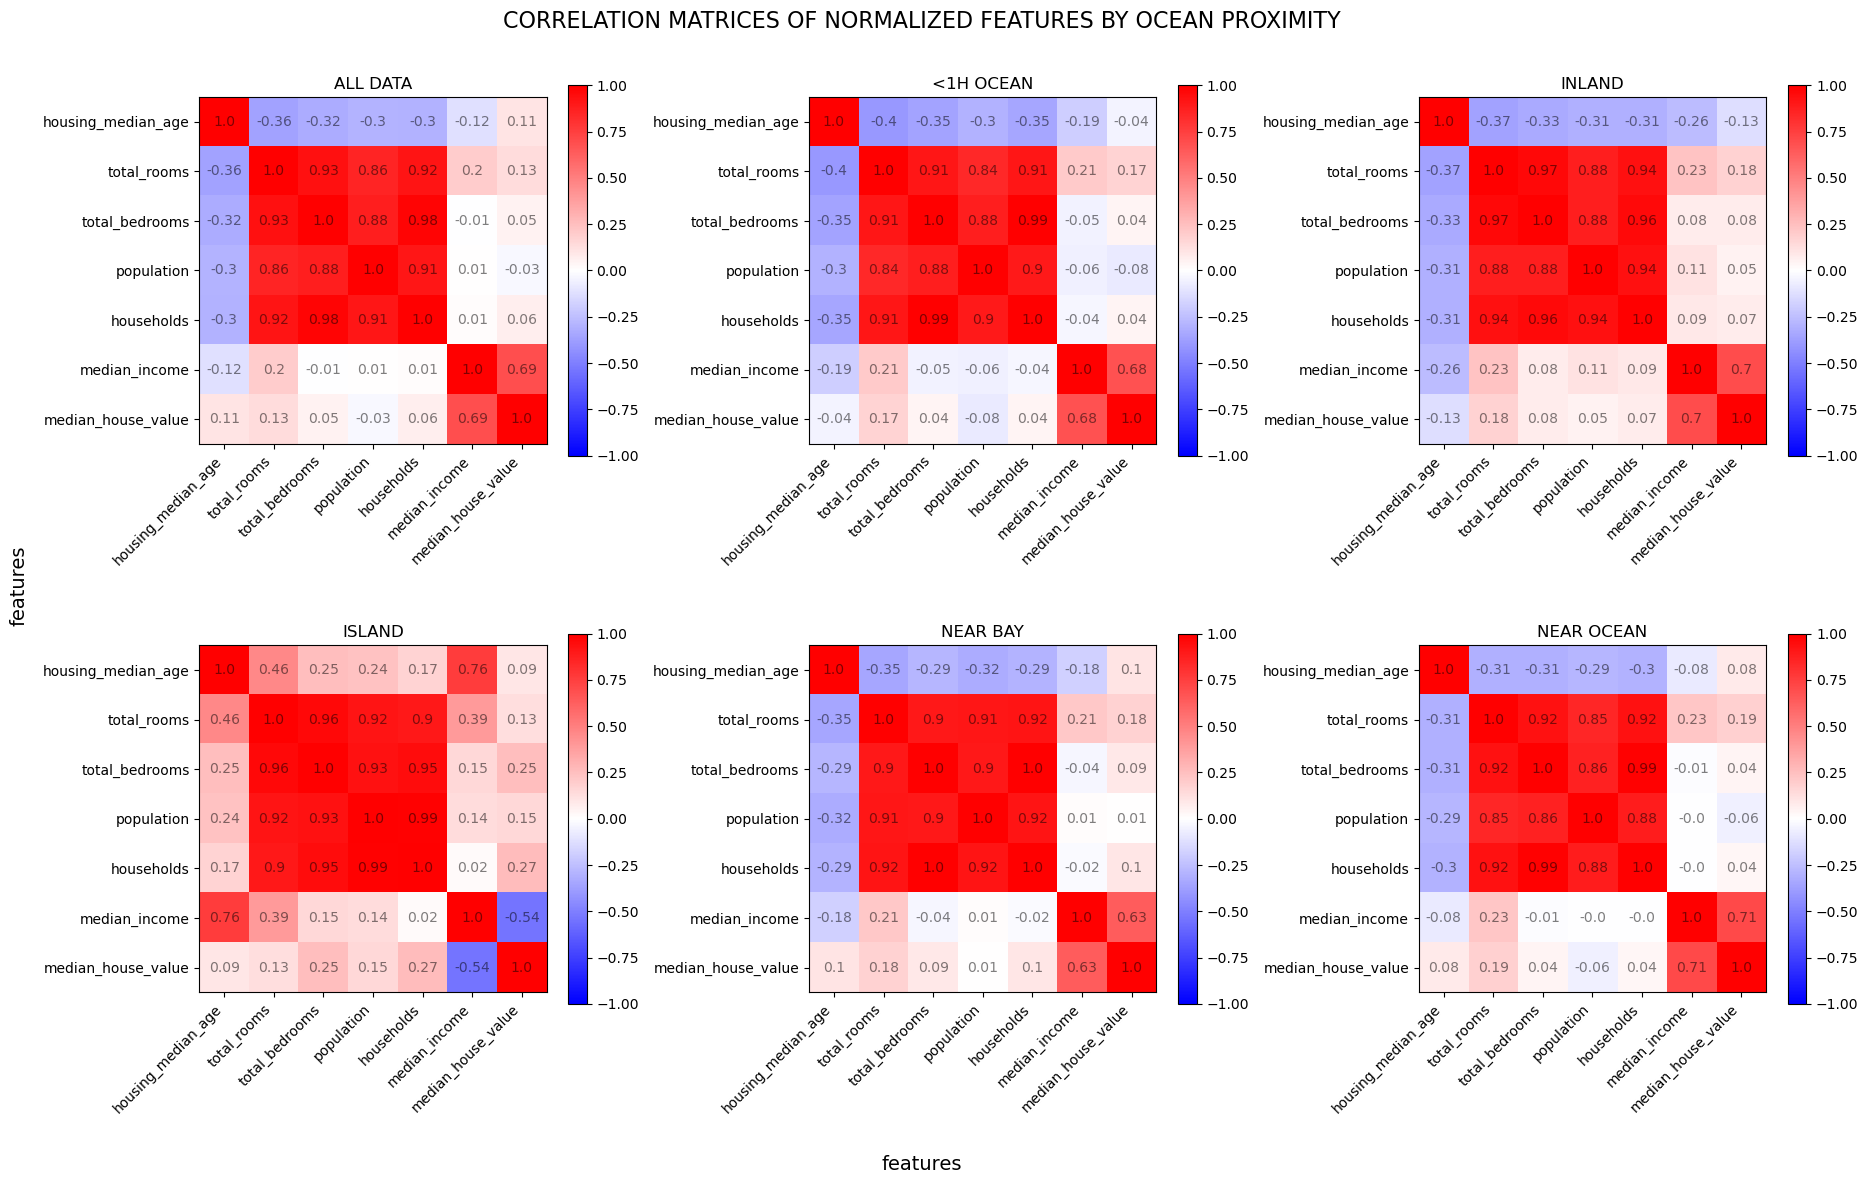

In [554]:
plot_one_hot_corr_matrix(
    dataset=scaled_data, 
    feature_cols=scaled_data.columns[2:9], 
    one_hot_cols=scaled_data.columns[9:14], 
    one_hot_title='OCEAN PROXIMITY', 
    tot_rows=2, 
    tot_cols=3, 
    figsize=(19,12), 
    output_file="correlation_matrix.png")

In [555]:
one_hot_data = scaled_data.where(scaled_data["ISLAND"] == 1).dropna()
corr = pearsonr(one_hot_data[scaled_data.columns[7]], one_hot_data[scaled_data.columns[8]])
print(corr)

(-0.5399125613410961, 0.3475990439985979)


In [556]:
def calculate_correlation_and_pvalues(dataset):
    """
    Calculates the correlation matrix and the corresponding p-value matrix for a given DataFrame.
    
    Parameters:
        - dataset: A Pandas DataFrame containing numerical data.
        
    Returns:
        - corr_matrix: A Pandas DataFrame containing the Pearson correlation coefficients.
        - pval_matrix: A Pandas DataFrame containing the corresponding p-values.
    """
    # Validate inputs
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("dataset must be a Pandas DataFrame.")
    
    # Initialize empty matrices for correlations and p-values
    cols = dataset.columns
    corr_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)
    pval_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)
    
    # Compute correlation and p-value for each pair of columns
    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                break
            else:
                # Calculate Pearson correlation and p-value
                corr, pval = pearsonr(dataset[col1], dataset[col2])
                corr_matrix.loc[col1, col2] = corr
                pval_matrix.loc[col1, col2] = pval
    
    return corr_matrix, pval_matrix

def filter_non_significant_vals(corr_matrix, pval_matrix, athreshold=0.05):
    """
    Filters out non-significant correlation values based on a p-value threshold.
    
    Parameters:
        - corr_matrix: A Pandas DataFrame containing Pearson correlation coefficients.
        - pval_matrix: A Pandas DataFrame containing the corresponding p-values.
        - athreshold: A float representing the p-value threshold for significance. 
        
    Returns:
        - filtered_corr_matrix: A Pandas DataFrame containing only significant correlations; 
          non-significant values are replaced with NaN.
    """
    # Validate inputs
    if not isinstance(corr_matrix, pd.DataFrame):
        raise TypeError("corr_matrix must be Pandas DataFrames.")
    if not isinstance(pval_matrix, pd.DataFrame):
        raise TypeError("pval_matrix must be Pandas DataFrames.")
    if not isinstance(athreshold, (float, int)):
        raise TypeError("athreshold must be a numerical value (float or int).")
    if not (0 <= athreshold <= 1):
        raise ValueError("athreshold must be between 0 and 1.")

    # Ensure the dimensions of corr_matrix and pval_matrix match
    if corr_matrix.shape != pval_matrix.shape:
        raise ValueError("corr_matrix and pval_matrix must have the same dimensions.")

    # Create a copy of the correlation matrix to avoid modifying the original
    filtered_corr_matrix = corr_matrix.copy()

    # Apply the threshold: set correlations to NaN where p-values exceed the threshold
    filtered_corr_matrix[pval_matrix > athreshold] = np.nan

    return filtered_corr_matrix

In [557]:
def plot_one_hot_significance(dataset, feature_cols, one_hot_cols, one_hot_title, athreshold, tot_rows, tot_cols, figsize, output_file="sig_corr_matrix.png"):
    """
    Plots histograms for selected features and a bar chart for one-hot-encoded column frequencies.

    Parameters:
        - dataset: Pandas DataFrame containing the data to be plotted. For better visualization the values should be normalized.
        - features: List of numerical feature column names to plot histograms for.
        - one_hot_cols: List of one-hot-encoded column names to plot frequency distributions for.
        - one_hot_title: String that describes the one_hot_cols.
        - athreshold: A float representing the p-value threshold for significance.
        - tot_rows: Number of rows in the subplot grid. 
        - tot_cols: Number of columns in the subplot grid.
        - figsize: Tuple specifying the figure size (width, height).
        - output_file: Name of the file to save the generated plot. Default is 'data_distribution.png'.

    Returns:
        None. Displays the plots and saves the figure as a file.
    """
    # Validate inputs
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("dataset must be a Pandas DataFrame.")
    if not isinstance(feature_cols, (list, pd.Index)) or not all(isinstance(f, str) for f in feature_cols):
        raise TypeError("feature_cols must be a list of column names (strings) or a Pandas Index.")
    if not isinstance(one_hot_cols, (list, pd.Index)) or not all(isinstance(c, str) for c in one_hot_cols):
        raise TypeError("one_hot_columns must be a list of column names (strings) or a Pandas Index.")
    if not isinstance(one_hot_title, str):
        raise TypeError("one_hot_title must be a string.")
    if not isinstance(athreshold, (float, int)):
        raise TypeError("athreshold must be a numerical value (float or int).")
    if not (0 <= athreshold <= 1):
        raise ValueError("athreshold must be between 0 and 1.")
    if not isinstance(tot_rows, int) or tot_rows <= 0:
        raise ValueError("tot_rows must be a positive integer.")
    if not isinstance(tot_cols, int) or tot_cols <= 0:
        raise ValueError("tot_cols must be a positive integer.")
    if not isinstance(figsize, tuple) or len(figsize) != 2 or not all(isinstance(val, (int, float)) and val > 0 for val in figsize):
        raise ValueError("figsize must be a tuple of two positive numbers (width, height).")
    if not isinstance(output_file, str):
        raise TypeError("output_file must be a string.")
    
    # Check if the number of subplots is compatible with the features to be plotted
    if tot_cols*tot_rows != (len(one_hot_cols)+1): # +1 for all one_hot_cols combined.
        print('WARNING: The total number of subplots is not compatible with the total number of features.')

    # Prepare the plot grid
    fig, axs = plt.subplots(tot_rows, tot_cols, figsize=figsize)
    row, col = 0, 0
    matrix, pvalues = calculate_correlation_and_pvalues(dataset[feature_cols])
    matrix = filter_non_significant_vals(matrix, pvalues, 0.05)
    ax = axs[row,col]
    m_plot = ax.imshow(matrix, cmap='bwr')
    plt.colorbar(m_plot, shrink = 0.8)
    ax.set_title("ALL DATA")
    ax.set_xticks(range(len(matrix)), feature_cols, rotation=45, ha='right')
    ax.set_yticks(range(len(matrix)), feature_cols)
    for i in range(len(feature_cols)):
        for j in range(len(feature_cols)):
            if np.isnan(matrix[feature_cols[i]][feature_cols[j]]) == False:
                ax.text(i, j, round(matrix[feature_cols[i]][feature_cols[j]],2), ha="center", va="center", color='black', alpha=0.5)
    col += 1
    
    for one_hot_col in one_hot_cols:
        ax =  axs[row,col]
        one_hot_data = dataset.where(dataset[one_hot_col] == 1).dropna()
        one_hot_data = one_hot_data[feature_cols]
        matrix, pvalues = calculate_correlation_and_pvalues(one_hot_data)
        matrix = filter_non_significant_vals(matrix, pvalues, 0.05) 
        m_plot = ax.imshow(matrix, cmap='bwr', vmin=-1, vmax=1)
        plt.colorbar(m_plot, shrink = 0.8)
        ax.set_title(one_hot_col)
        ax.set_xticks(range(len(matrix)), feature_cols, rotation=45, ha='right')
        ax.set_yticks(range(len(matrix)), feature_cols)
        for i in range(len(feature_cols)):
            for j in range(len(feature_cols)):
                if np.isnan(matrix[feature_cols[i]][feature_cols[j]]) == False:
                    ax.text(i, j, round(matrix[feature_cols[i]][feature_cols[j]],2), ha="center", va="center", color='black', alpha=0.5)
        col = col + 1
        if col >= tot_cols:
            row = row + 1
            col = 0

    for ax in fig.get_axes():
        ax.label_outer()

    fig.suptitle(f"STATISTICALLY SIGNIFICANT CORRELATIONS OF NORMALIZED FEATURES BY {one_hot_title}", fontsize=16)
    fig.supylabel("features\n", fontsize=14)
    fig.supxlabel("features", fontsize=14)
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()

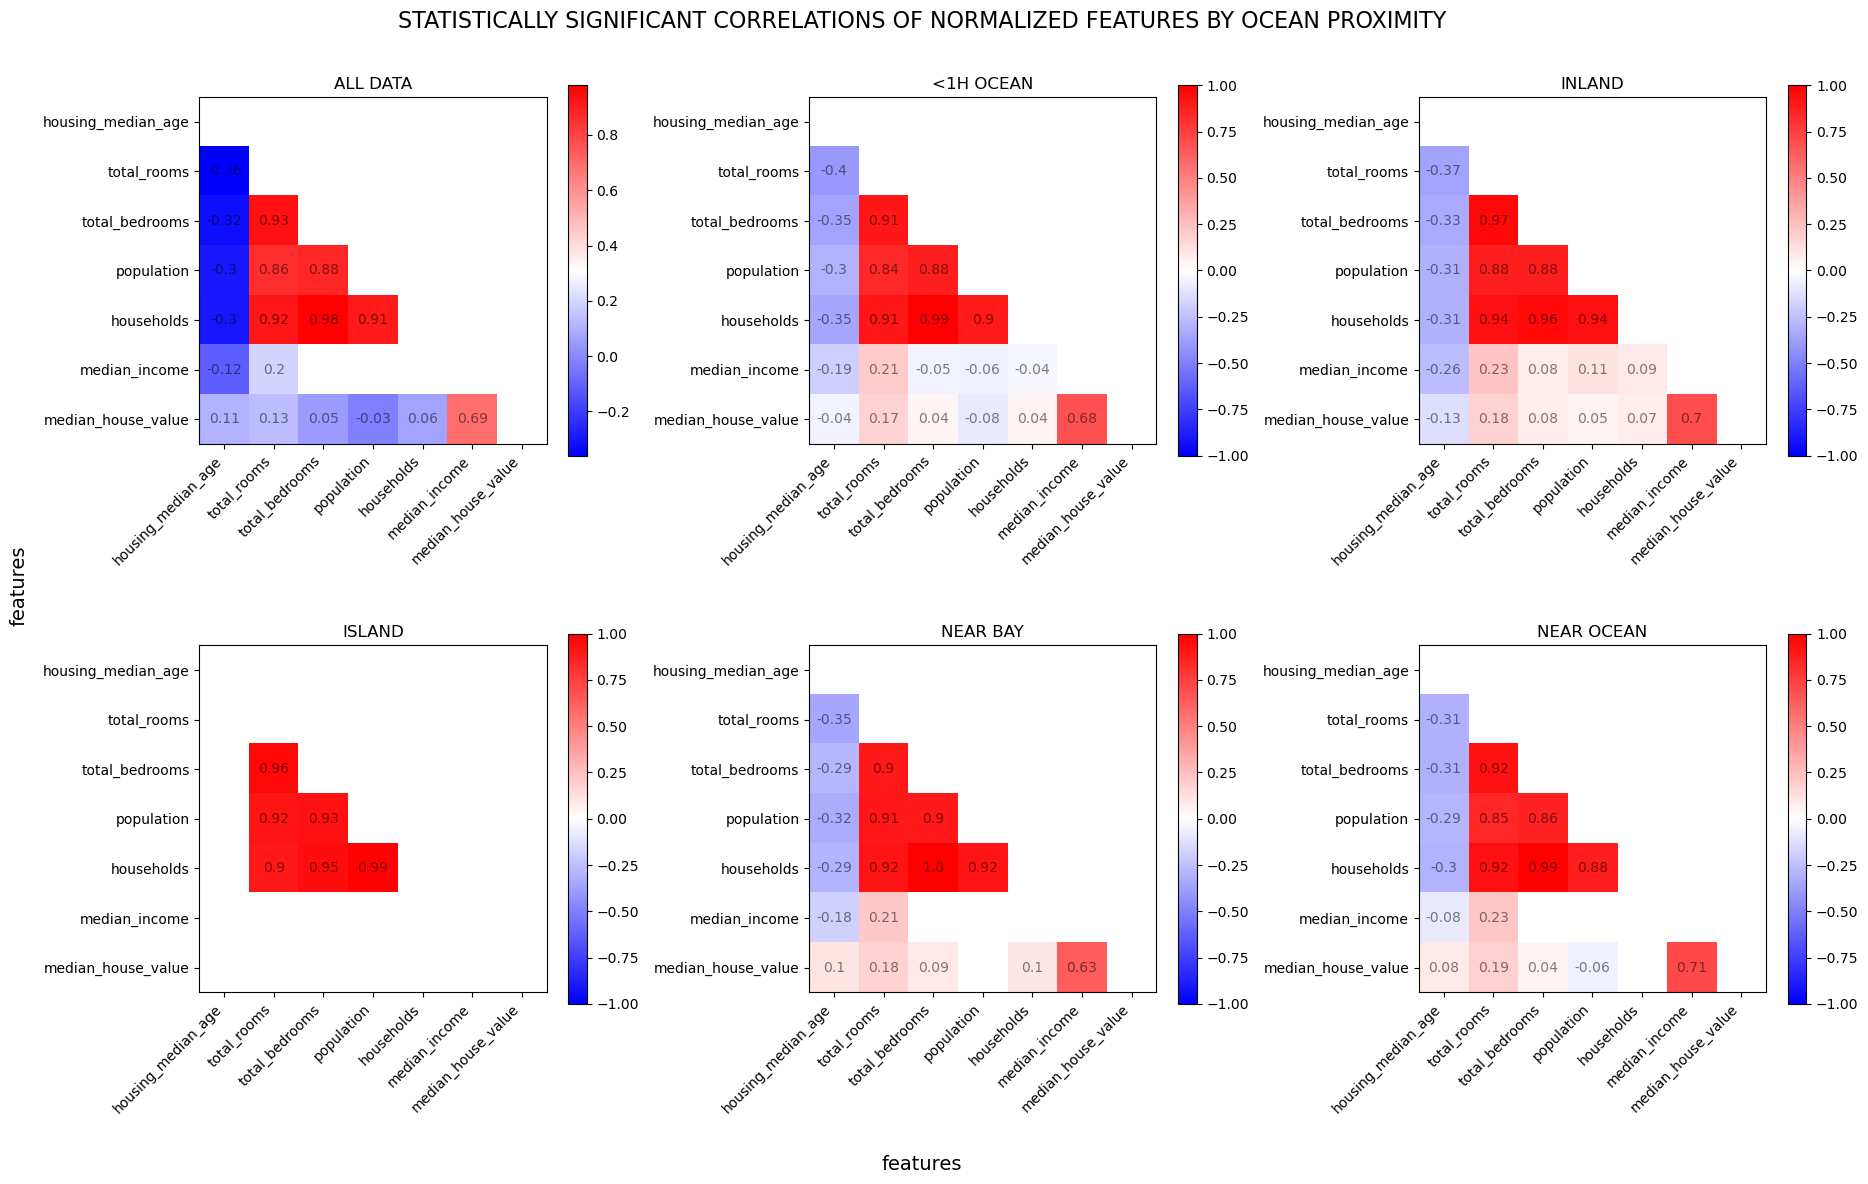

In [558]:
plot_one_hot_significance(
    dataset=scaled_data, 
    feature_cols=scaled_data.columns[2:9], 
    one_hot_cols=scaled_data.columns[9:14], 
    one_hot_title='OCEAN PROXIMITY', 
    athreshold=0.05,
    tot_rows=2, 
    tot_cols=3, 
    figsize=(19,12), 
    output_file="sig_corr_matrix.png")

In [559]:
a=[0]*3
print(a)
i=1
i+=1
print(i)

[0, 0, 0]
2
